In [39]:
"""
RCA using 5 Whys Technique - LangGraph Prototype
Uses Qwen/Qwen3-4B-Instruct-2507 for root cause analysis
"""

# Installation (run in Colab)
# !pip install -q transformers torch langgraph langchain-core accelerate

from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

In [40]:
# ============================================================================
# STATE DEFINITION
# ============================================================================

class RCAState(TypedDict):
    """State for RCA workflow"""
    problem: str  # Initial problem description
    why_no: int  # Current why iteration (0-5)
    whys: list[dict]  # List of {question, answer} pairs
    root_cause: str  # Extracted root cause
    confidence_score: float  # Confidence in root cause (0-100)
    report: str  # Final RCA report
    user_input: str  # User's answer to current why
    needs_validation: bool  # Flag for answer validation
    retry_count: int  # Number of validation retries

In [41]:
# ============================================================================
# MODEL LOADING
# ============================================================================

print("Loading model...")
model_name = "Qwen/Qwen2.5-3B-Instruct"  # Using 2.5-3B as it's more accessible

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)

# Create pipeline
llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=800,
    temperature=0.7,
    do_sample=True
)

print("Model loaded successfully!")

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded successfully!


In [42]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def generate_response(prompt: str) -> str:
    """Generate response from LLM"""
    messages = [{"role": "user", "content": prompt}]
    result = llm_pipeline(messages)
    return result[0]["generated_text"][-1]["content"].strip()

def format_whys_context(whys: list[dict]) -> str:
    """Format previous whys for context"""
    if not whys:
        return "No previous whys yet."

    context = ""
    for i, why in enumerate(whys, 1):
        context += f"Why {i}: {why['question']}\nAnswer: {why['answer']}\n\n"
    return context.strip()

def calculate_answer_quality_score(whys: list[dict]) -> float:
    """Calculate average quality score of all answers"""
    if not whys:
        return 0.0

    total_score = sum(why.get('quality_score', 3.0) for why in whys)
    return (total_score / len(whys)) / 5.0 * 100  # Convert to percentage

In [43]:
# ============================================================================
# PROMPT DEFINITIONS
# ============================================================================

def create_why_prompt(problem: str, why_no: int, previous_whys: str) -> str:
    """Create prompt for asking why question"""
    if why_no == 1:
        return f"""You are conducting a Root Cause Analysis using the 5 Whys technique.

Problem/Incident: {problem}

Generate the first "Why" question to dig deeper into this problem. The question should be direct and help understand the underlying cause.

Format your response as:
Why 1: [your question here]"""
    else:
        return f"""You are conducting a Root Cause Analysis using the 5 Whys technique.

Problem/Incident: {problem}

Previous questions and answers:
{previous_whys}

Generate the next "Why" question (Why {why_no}) based on the previous answer. Dig deeper into the root cause.

Format your response as:
Why {why_no}: [your question here]"""

def create_root_cause_prompt(problem: str, whys_context: str) -> str:
    """Create prompt for extracting root cause"""
    return f"""You are analyzing a Root Cause Analysis session using the 5 Whys technique.

Problem/Incident: {problem}

5 Whys Analysis:
{whys_context}

Based on this analysis, extract and state the root cause in 1-2 clear sentences. Be specific and actionable.

Root Cause:"""

def create_validation_prompt(question: str, answer: str) -> str:
    """Create prompt for validating user answer"""
    return f"""You are validating an answer in a Root Cause Analysis session.

Question: {question}
Answer: {answer}

Evaluate the answer on these criteria:
1. Specificity: Is the answer concrete and detailed, or vague and generic? (Rate 1-5, where 5 is very specific)
2. Relevance: Does the answer actually address the question asked? (Rate 1-5, where 5 is highly relevant)

Respond in this exact format:
Specificity: [score]
Relevance: [score]
Needs Improvement: [yes/no]
Suggestion: [If needs improvement, provide a brief suggestion for what additional details would help]"""

def create_report_prompt(problem: str, whys_context: str, root_cause: str, confidence: float) -> str:
    """Create prompt for generating final report"""
    return f"""Generate a professional Root Cause Analysis report following standard RCA format.

Problem/Incident: {problem}

Analysis Process:
{whys_context}

Root Cause: {root_cause}
Confidence Level: {confidence:.1f}%

Create a comprehensive RCA report with these sections:

1. EXECUTIVE SUMMARY
   - Brief overview of the incident and root cause

2. PROBLEM STATEMENT
   - Detailed description of the problem
   - Impact and severity

3. ANALYSIS METHODOLOGY
   - 5 Whys technique applied

4. DETAILED ANALYSIS
   - Document each Why and its answer

5. ROOT CAUSE IDENTIFICATION
   - The identified root cause
   - Confidence level and reasoning

6. CORRECTIVE ACTIONS
   - Immediate corrective actions (2-3 items)
   - Long-term preventive measures (2-3 items)

7. RECOMMENDATIONS
   - Process improvements
   - Monitoring and follow-up suggestions

Keep the report professional, structured, and actionable."""

In [44]:
# ============================================================================
# NODE DEFINITIONS
# ============================================================================

def why_asker(state: RCAState) -> RCAState:
    """Node that generates why questions"""
    print(f"\n{'='*60}")
    print(f"WHY ASKER NODE - Iteration {state['why_no'] + 1}")
    print(f"{'='*60}")

    # Increment why number
    state["why_no"] += 1

    # Generate why question
    previous_whys = format_whys_context(state["whys"])
    prompt = create_why_prompt(state["problem"], state["why_no"], previous_whys)
    why_question = generate_response(prompt)

    # Extract just the question part
    if ":" in why_question:
        why_question = why_question.split(":", 1)[1].strip()

    print(f"\nGenerated Question: {why_question}")

    # Get user input
    print("\nWaiting for your answer...")
    user_answer = input(f"Your answer to Why {state['why_no']}: ").strip()

    # Store the why and answer temporarily (will be validated)
    state["user_input"] = user_answer
    state["needs_validation"] = True
    state["retry_count"] = 0

    # Store current question for validation
    state["current_question"] = why_question

    return state

def answer_validator(state: RCAState) -> RCAState:
    """Node that validates user answers for quality"""
    print(f"\n{'='*60}")
    print("ANSWER VALIDATOR NODE")
    print(f"{'='*60}")

    question = state.get("current_question", "")
    answer = state.get("user_input", "")

    # Generate validation
    validation_prompt = create_validation_prompt(question, answer)
    validation_response = generate_response(validation_prompt)

    print(f"\nValidating answer...")

    # Parse validation response
    specificity = 3.0  # Default
    relevance = 3.0    # Default
    needs_improvement = False

    for line in validation_response.split('\n'):
        if 'Specificity:' in line:
            try:
                specificity = float(line.split(':')[1].strip().split()[0])
            except:
                pass
        elif 'Relevance:' in line:
            try:
                relevance = float(line.split(':')[1].strip().split()[0])
            except:
                pass
        elif 'Needs Improvement:' in line:
            needs_improvement = 'yes' in line.lower()

    # Calculate quality score
    quality_score = (specificity + relevance) / 2

    print(f"Specificity: {specificity}/5")
    print(f"Relevance: {relevance}/5")
    print(f"Quality Score: {quality_score:.1f}/5")

    # Check if answer needs improvement
    if needs_improvement and quality_score < 3.0 and state.get("retry_count", 0) < 1:
        print(f"\n⚠️  Answer could be more specific or relevant.")
        suggestion = validation_response.split('Suggestion:')[-1].strip() if 'Suggestion:' in validation_response else "Please provide more details."
        print(f"Suggestion: {suggestion}")

        # Ask for improved answer
        improved_answer = input(f"\nPlease provide a more detailed answer (or press Enter to keep current): ").strip()

        if improved_answer:
            state["user_input"] = improved_answer
            state["retry_count"] = state.get("retry_count", 0) + 1
            # Re-validate
            return answer_validator(state)

    # Accept the answer
    state["whys"].append({
        "question": question,
        "answer": state["user_input"],
        "quality_score": quality_score
    })

    state["needs_validation"] = False
    print(f"✓ Answer accepted")

    return state

def root_cause_extractor(state: RCAState) -> RCAState:
    """Node that extracts root cause"""
    print(f"\n{'='*60}")
    print("ROOT CAUSE EXTRACTOR NODE")
    print(f"{'='*60}")

    whys_context = format_whys_context(state["whys"])
    prompt = create_root_cause_prompt(state["problem"], whys_context)

    root_cause = generate_response(prompt)
    state["root_cause"] = root_cause

    # Calculate confidence score
    answer_quality = calculate_answer_quality_score(state["whys"])

    # Factors for confidence:
    # 1. Answer quality (0-100)
    # 2. Completeness (did we do all 5 whys?) - 20 points
    # 3. Logical flow bonus - 10 points

    completeness_score = 20 if len(state["whys"]) == 5 else (len(state["whys"]) / 5 * 20)
    logical_flow_bonus = 10  # Simplified for MVP

    confidence = (answer_quality * 0.7) + completeness_score + logical_flow_bonus
    confidence = min(100, max(0, confidence))  # Clamp between 0-100

    state["confidence_score"] = confidence

    print(f"\nExtracted Root Cause: {root_cause}")
    print(f"\n📊 Confidence Score: {confidence:.1f}%")
    print(f"   - Answer Quality: {answer_quality:.1f}%")
    print(f"   - Completeness: {completeness_score:.1f}/20")
    print(f"   - Logical Flow: {logical_flow_bonus}/10")

    return state

def report_generator(state: RCAState) -> RCAState:
    """Node that generates final report"""
    print(f"\n{'='*60}")
    print("REPORT GENERATOR NODE")
    print(f"{'='*60}")

    whys_context = format_whys_context(state["whys"])
    prompt = create_report_prompt(
        state["problem"],
        whys_context,
        state["root_cause"],
        state["confidence_score"]
    )

    report = generate_response(prompt)
    state["report"] = report

    print("\n" + "="*60)
    print("STANDARDIZED RCA REPORT")
    print("="*60)
    print(report)
    print("\n" + "="*60)
    print(f"Overall Confidence: {state['confidence_score']:.1f}%")
    print("="*60)

    return state

In [45]:
# ============================================================================
# ROUTING LOGIC
# ============================================================================

def should_continue_or_validate(state: RCAState) -> str:
    """Decide next node: validate answer or continue/extract"""
    if state.get("needs_validation", False):
        return "validate"
    elif state["why_no"] < 5:
        return "continue"
    else:
        return "extract"

# ============================================================================
# GRAPH BUILDING
# ============================================================================

# Initialize graph
workflow = StateGraph(RCAState)

# Add nodes
workflow.add_node("why_asker", why_asker)
workflow.add_node("answer_validator", answer_validator)
workflow.add_node("root_cause_extractor", root_cause_extractor)
workflow.add_node("report_generator", report_generator)

# Set entry point
workflow.set_entry_point("why_asker")

# Add conditional edges from why_asker
workflow.add_conditional_edges(
    "why_asker",
    should_continue_or_validate,
    {
        "validate": "answer_validator",
        "continue": "why_asker",
        "extract": "root_cause_extractor"
    }
)

# Add conditional edges from answer_validator
workflow.add_conditional_edges(
    "answer_validator",
    should_continue_or_validate,
    {
        "continue": "why_asker",
        "extract": "root_cause_extractor"
    }
)

# Add edge from root_cause_extractor to report_generator
workflow.add_edge("root_cause_extractor", "report_generator")

# Add edge from report_generator to END
workflow.add_edge("report_generator", END)

# Compile graph
app = workflow.compile()

print("\n" + "="*60)
print("RCA GRAPH COMPILED SUCCESSFULLY!")
print("="*60)


RCA GRAPH COMPILED SUCCESSFULLY!


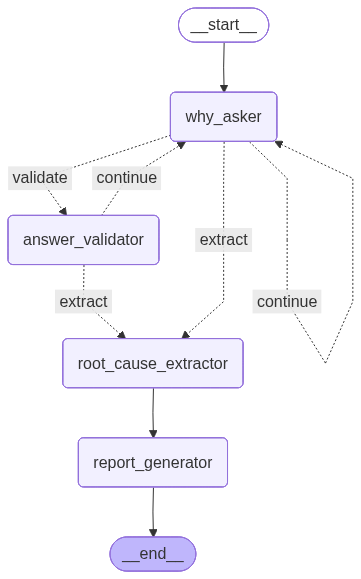

In [46]:
app

In [47]:
# ============================================================================
# TEST EXECUTION
# ============================================================================

def run_rca_analysis(problem_description: str):
    """Run RCA analysis for a given problem"""

    print("\n" + "="*60)
    print("STARTING RCA ANALYSIS")
    print("="*60)
    print(f"\nProblem: {problem_description}\n")

    # Initialize state
    initial_state = {
        "problem": problem_description,
        "why_no": 0,
        "whys": [],
        "root_cause": "",
        "confidence_score": 0.0,
        "report": "",
        "user_input": "",
        "needs_validation": False,
        "retry_count": 0,
        "current_question": ""
    }

    # Run the graph
    final_state = app.invoke(initial_state)

    return final_state

In [48]:
# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example problem
    problem = "The production server crashed at 3 AM causing 2 hours of downtime"

    print("\n" + "#"*60)
    print("READY TO START RCA ANALYSIS")
    print("#"*60)
    print("\nYou can now run:")
    print('final_state = run_rca_analysis("Your problem description here")')
    print("\nExample:")
    print(f'final_state = run_rca_analysis("{problem}")')

    # Uncomment below to run automatically
    final_state = run_rca_analysis(problem)


############################################################
READY TO START RCA ANALYSIS
############################################################

You can now run:
final_state = run_rca_analysis("Your problem description here")

Example:
final_state = run_rca_analysis("The production server crashed at 3 AM causing 2 hours of downtime")

STARTING RCA ANALYSIS

Problem: The production server crashed at 3 AM causing 2 hours of downtime


WHY ASKER NODE - Iteration 1

Generated Question: Why did the production server crash at 3 AM?

Waiting for your answer...
Your answer to Why 1: The database ran out of something I guess

ANSWER VALIDATOR NODE

Validating answer...
Specificity: 2.0/5
Relevance: 1.0/5
Quality Score: 1.5/5

⚠️  Answer could be more specific or relevant.
Suggestion: The answer "The database ran out of something I guess" is too vague. It's unclear what specifically the database ran out of, such as storage space, connections, or memory. Providing more details like "The da